# Advances to Unit and Simulation Composition

Throughout these teaching notebooks, we're going to take you step-by-step through the development and considerations we make when producing an simulation software that uses units.

In this notebook (**2**) we are going to cover:

- **[Modifications to the simulation (adding stopping)](#s1)**
- **[Simulating larger groups](#s2)**
- **[Packaging positioning assignment](#s3)**

Click on any of the links to jump to that section.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

sys.path.insert(0, "../")
%matplotlib inline

We import our `battlesim` package locally:

In [2]:
import battlesim as bsm

## <a id='s1'> Modifications to the simulation

If you recall from the previous notebook, we had made a `Unit` class that has an initialization method that basically sets attributes to each Unit:

    class Unit(object):
        def __init__(self, db, name):
            """
            Defines a unit, based on examples in the 'db' file, given a name. Assumes the name
            is the index in db.
            """
            # check that name is in db.index
            if not name in db.index:
                raise ValueError("unit {} must be in {}".format(name, db.index))
            self.name = name
            self.hp = db.loc[name, "HP"]
            self.dmg = db.loc[name, "Damage"]
            self.range = db.loc[name, "Range"]
            self.speed = db.loc[name, "Movement Speed"]
            self.team = db.loc[name, "allegiance_int"]
            self.team_name = db.loc[name, "Allegiance"]

            # define position
            self.pos = np.array([0., 0.])
            # directional derivative from target. 
            self.dd = np.array([0., 0.])
            # distance from target
            self.dist = 0.
            # define target to aim for
            self.target = None
            
We have defined this within a `legacy` section of the package: which we call `Unit1`:

In [3]:
bsm.legacy.Unit1

battlesim.legacy.Unit1

In our previous example, the health bar of the enemies just kept decreasing until we timed out. This is because in our simulation example there is no accounting for this.

    def basic_simulation2(units, max_step=50):
    t = 0
    running = True
    
    steps = []
    
    # while loop
    while running and t < max_step:
        # iterate over units.
        for i, u in enumerate(units):
            #if we're alive...
            if u.hp > 0:
                # euclidean distance
                u.dd = deriv_norm(u.pos, u.target.pos)
                u.dist = euclidean(u.pos, u.target.pos)
                # now, if the unit is not in range, then move towards it
                if u.dist > u.range:
                    # speed modifier added, others ignored from above.
                    u.pos += dudt(u.pos, u.target.pos, u.speed)
                else:
                    # perform damage to enemy health.
                    u.target.hp -= u.dmg
            
            # save
            steps.append(deepcopy(units))
        t += 1
    
    return steps
    
So we need to check after our unit is alive *whether the enemy unit is alive*. Also we have the problem of, what happens once the enemy target is dead - we need to find another enemy to attack! 

### Assigning random enemies

For simplicity, we assign each unit a random enemy, as:

\begin{align}
T_i \sim \mathcal{U}(0, N_j-1)
\end{align}

where $T_i$ is the index of the $j$th target for unit $i$, within the $N$-space of the enemies. $\mathcal{U}$ refers to the uniform distribution, in the sense that there is an *equal chance that any enemy can be picked*.

To do this we'll write a function `find_random_enemy()` that, given a unit and a list of all units, finds a new alive enemy.

In [4]:
import random
from copy import deepcopy

In [5]:
def find_random_enemy(u, units):
    """Where u is the chosen unit, units is a list of all units."""
    # generate list of alive enemies
    alive_enemies = [i for i in units if (i.hp > 0) and (i.team != u.team)]
    # hang on, what if there are no alive enemies?
    if len(alive_enemies) > 0:
        return random.choice(alive_enemies)
    else:
        return -1

In [6]:
def basic_simulation3(units, max_step=50):
    t = 0
    running = True
    
    steps = []
    
    # while loop
    while running and t < max_step:
        # iterate over units.
        for i, u in enumerate(units):
            #if we're alive...
            if u.hp > 0:
                
                # wait a second. what if our enemy is dead..?
                if u.target.hp <= 0.:
                    # find a new random enemy.
                    target = find_random_enemy(u, units)
                    if target != -1:
                        u.target = target
                    else:
                        # no more enemies - stop!
                        running = False
                        
                """Only do all this once we have a valid target..."""
                # euclidean distance
                u.dd = bsm.legacy.deriv_norm(u.pos, u.target.pos)
                u.dist = bsm.legacy.euclidean(u.pos, u.target.pos)
                # now, if the unit is not in range, then move towards it
                if u.dist > u.range:
                    # speed modifier added, others ignored from above.
                    u.pos += bsm.legacy.dudt(u.pos, u.target.pos, u.speed)
                else:
                    # perform damage to enemy health.
                    u.target.hp -= u.dmg
            
            # save
            steps.append(deepcopy(units))
        t += 1
    
    return steps

### Defining basics again - making units and getting db access.

In [7]:
db_ = bsm.legacy.import_db_file("../datasets/starwars-clonewars.csv")

In [8]:
# define units.
u1 = bsm.legacy.Unit1(db_, "Clone Trooper")
u2 = bsm.legacy.Unit1(db_, "B1 battledroid")
u3 = bsm.legacy.Unit1(db_, "Clone Trooper")
u4 = bsm.legacy.Unit1(db_, "B1 battledroid")

u1.pos = np.array([-5., 5.])
u3.pos = np.array([5., 5.])

u1.target = u2
u3.target = u4
u2.target = u1
u4.target = u3

### Simulate using new simulation

Here we see a marked difference in the simulation - only 28 timesteps instead of 100!!

In [9]:
Res = basic_simulation3([u1, u2, u3, u4])
pos = bsm.legacy.extract_pos(Res,4)
dpos = bsm.legacy.extract_dpos(Res,4)
H_p = bsm.legacy.extract_hp(Res,4)

In [10]:
pos.shape

(28, 2, 4)

In [11]:
len(Res)

28

And we'll write a function `plot_quiver` for convenience whenever we which to see the movement of the units.

In [12]:
def plot_quiver(pos, dpos):
    for i in range(pos.shape[-1]):
        plt.scatter(pos[:, 0, i], pos[:, 1, i])
        plt.quiver(pos[:, 0, i], pos[:, 1, i], dpos[:, 0, i], dpos[:, 1, i])

    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

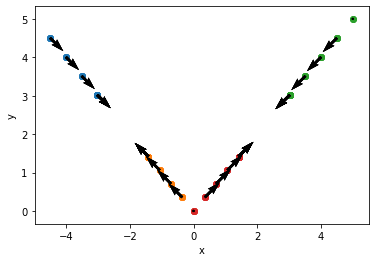

In [13]:
plot_quiver(pos, dpos)

And plotting the health change among the units - it's considerably more controlled - no more extreme negative numbers.

In [14]:
def plot_hp(HP):
    for i, x in enumerate(HP):
        plt.plot(x, alpha=.5)
    plt.xlabel("time")
    plt.ylabel("HP")
    plt.show()

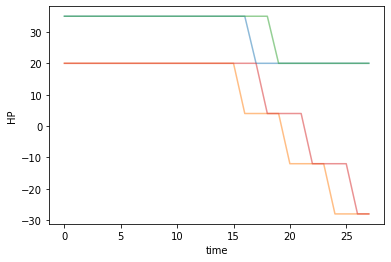

In [15]:
plot_hp(H_p)

## <a id='s2'> Simulating larger groups

It's interesting to see what happens to 4 units, but what about if I want 40? How do the behaviors change within the units once we factor in these intra-dynamics?

Here we will create 2 groups using *list comprehensions*, assign a random location to each group using a **Gaussian distribution** and then begin the simulation again.

### Gaussian distribution

A gaussian or normal distribution is a common continuous probability that can be used to represent real-valued random variables. Informally known as the bell-curve, it is described as:

\begin{align}
f(x|\mu, \sigma^2)=\frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x-\mu)^2}{2 \sigma^2}}
\end{align}

where $\mu$ is the mean or expectation, $\sigma^2$ is the variance. A special case exists where $f(x|0, 1)$, known as the standard normal distribution:

\begin{align}
f(x|0, 1)=\frac{1}{\sqrt{2 \pi}}e^{-\frac{1}{2}x^2}
\end{align}

### Sampling from a Gaussian distribution

The normal distribution is often referred to as $\mathcal{N}(\mu, \sigma^2)$. Thus our position coordinates $\mathbf{u}$ can be initialized as:

\begin{align}
\mathbf{u} \sim \mathcal{N}(\mu, \sigma^2)
\end{align}

Separate $\mu$ and $\sigma^2$ can be given to each dimension in $\mathbf{u}$ if you want the distribution to lie off of the $x=y$ axis. All of this is achieved using the `np.random.normal` function, specifying $\mu$, $\sigma^2$, and a sample size $n$.

In [16]:
group1 = [bsm.legacy.Unit1(db_, "Clone Trooper") for i in range(20)]
group2 = [bsm.legacy.Unit1(db_, "B1 battledroid") for i in range(20)]

Apply gauss distribution to the positions:

In [17]:
for u in group1:
    u.pos = np.random.normal(loc=0, scale=1, size=(2,))
for u in group2:
    u.pos = np.random.normal(loc=10, scale=1, size=(2,))

### Assigning each unit a *random* enemy

Assign each unit a random enemy target using our previously defined function.

In [18]:
for u in group1:
    u.target = find_random_enemy(u, group2)
for u in group2:
    u.target = find_random_enemy(u, group1)

In [19]:
Res = basic_simulation3(group1 + group2)
pos = bsm.legacy.extract_pos(Res,40)
dpos = bsm.legacy.extract_dpos(Res,40)
H_p = bsm.legacy.extract_hp(Res,40)

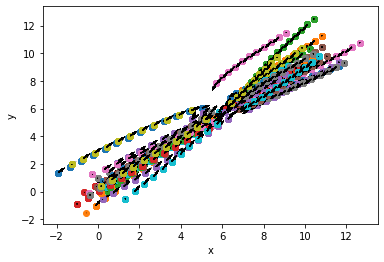

In [20]:
plot_quiver(pos, dpos)

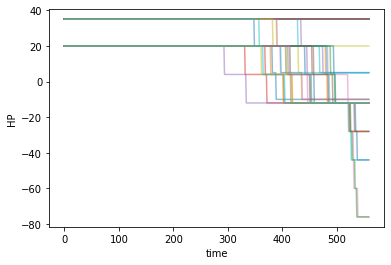

In [21]:
plot_hp(H_p)

## <a id='s3'> Packaging position and enemy assignment

Of course we could decide that we want to manually assign all of this beforehand, but it's far nicer to call one function, saying how many units we want to create, with what position, and some method of saying, "Just choose a random enemy please".

To do this, we will create a new function `create_unit_group` to do exactly this.

In addition to this, once we have created all of the units, we want to **randomly assign enemies** to each unit, which we can do by passing a list of every unit, and relying on the flags associated in each `Unit` object to identify teams.

In [64]:
def create_unit_group(df, u_type, n, pos_params):
    """
    Given a unit type, database, n sample and position params, create a unit group blob 
    using gaussian.
    
    pos_params should be a tuple (2,) for mean and var.
    
    we cannot however assign enemies without a list to draw from, so this might have
    to be assigned after this function.
    """
    
    units = [bsm.legacy.Unit1(df, u_type) for i in range(n)]
    for u in units:
        u.pos = np.random.normal(*pos_params, size=(2,))
    return units

In [65]:
group1 = create_unit_group(db_, "Clone Trooper", 20, (0., 1.))
group2 = create_unit_group(db_, "B1 battledroid", 20, (10., 1.))

### Enemy assignment to all groups

In [66]:
def assign_enemies(units):
    # get team ids
    for u in units:
        u.target = find_random_enemy(u, units)

In [67]:
assign_enemies(group1+group2)

And now we re-run the simulation:

In [69]:
Res = basic_simulation3(group1+group2)

pos = bsm.legacy.extract_pos(Res,40)
dpos = bsm.legacy.extract_dpos(Res,40)
H_p = bsm.legacy.extract_hp(Res,40)

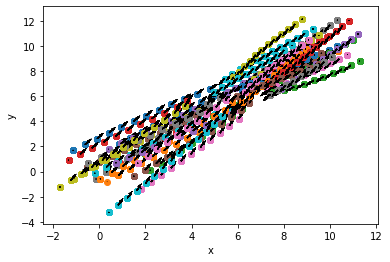

In [70]:
plot_quiver(pos, dpos)

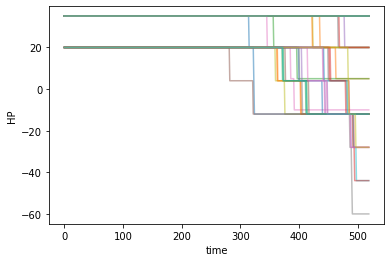

In [71]:
plot_hp(H_p)

We won't cover any more in this notebook - we mainly rehash ideas discussed in the previous notebook; however the next work is a serious step up from where we currently are.